In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import math
import copy

In [3]:
def calc_k_A(k_0,gain,locomotor_strength):
    deltaG = gain - 1
    k_A = k_0*(1+deltaG*(1-locomotor_strength))
    return k_A

def update_position(dt,x,gain,v):
    x_new = x + dt*gain*v
    x_new = x_new % 400
    return x_new

def update_phaseLM(dt,phi_L,k_L,v):
    phi_L_new = phi_L + dt*k_L*v
    phi_L_new = phi_L_new % (2*np.pi)
    return phi_L_new

def update_phase_cts_visInput(dt,phi_A,x,gain,v,k_A,k_L,strength_LM,phi_L):
    input_vel = k_A*v
    input_LM = strength_LM*np.sin(phi_L-phi_A)
    x_new = update_position(dt,x,gain,v)
    phi_L_new = update_phaseLM(dt,phi_L,k_L,v)
    dphi_A = dt*(input_vel + input_LM)
    phi_A_new = (phi_A + dphi_A) % (2*np.pi) 
    return phi_A_new, x_new, phi_L_new, input_LM

def calc_decoherence(k_0,v,locomotor_strength,gain,strength_LM):
    return -k_0*v*locomotor_strength*(gain-1)/strength_LM

# eq. 17 & 18 
def phase_shift_ana(decoherence, k0,k_L):
    deltax = asin(decoherence)/k0
    deltatheta = k_L*deltax
    return deltatheta

In [8]:
v = 3                    # Animal velocity (cm/s)
#k_0 = 2*np.pi/100        # Conversion from linear track to ring when gain = 1
k_0 = 2*np.pi/100  
g = 2           # Gain factor
locomotor_strength = 0.5  # Between 0 and 1
#g = np.linspace(-3,5,num=100)
dt = 1 # (second)
strength_LM = 0.1 # Keep small

decoherence = calc_decoherence(k_0,v,locomotor_strength,g,strength_LM)
print(f'Decoherence number is {decoherence}')

Decoherence number is -0.9424777960769379


In [7]:
def parameter_search_g(g):
    decoherence_A = np.zeros(len(g))
    major_freq_A = np.zeros(len(g))
    constant_phase_A = np.zeros(len(g))
    for i in range(len(g)):
        k_A = calc_k_A(k_0,g[i],locomotor_strength)
        k_L = g[i]*k_0
        decoherence_A[i] = calc_decoherence(k_0,v,locomotor_strength,g[i],strength_LM)
        phi_A_t, phi_L_t, deltaPhi = find_phase_difference(g[i], k_A, k_L, time=1000)
        major_freq = calc_major_freq(deltaPhi)
        major_freq_A[i] = major_freq
        if major_freq == 0:
            constant_phase_A[i] = calc_constant_dPhi(deltaPhi)
    return decoherence_A, major_freq_A, constant_phase_A


In [ ]:
decoherence_A, major_freq_A, constant_phase_A = parameter_search_g(g)

Text(0, 0.5, 'stable phase difference value')

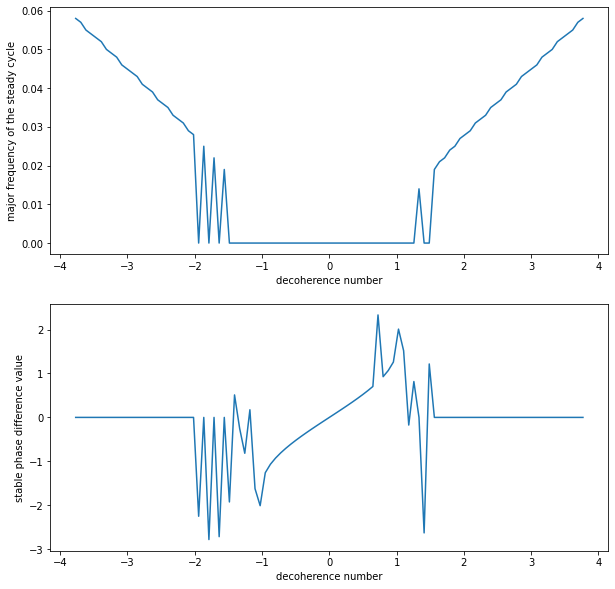

In [ ]:
fig4, ax4 = plt.subplots(2,1,figsize=(10,10))
ax4[0].plot(decoherence_A, major_freq_A)
ax4[0].set_xlabel('decoherence number')
ax4[0].set_ylabel('major frequency of the steady cycle')
ax4[1].plot(decoherence_A, constant_phase_A)
ax4[1].set_xlabel('decoherence number')
ax4[1].set_ylabel('stable phase difference value')

In [22]:
# Initialization
def find_phase_difference(g, k_A, k_L,time=1000):
    phi_A = 0
    phi_L = 0
    x=0

    phi_A_t = []
    phi_L_t = []
    x_t = []
    input_LM_t = []

    for t in range(time):
        phi_A, x, phi_L, input_LM = update_phase_cts_visInput(dt,phi_A,x,g,v,k_A,k_L,strength_LM,phi_L)
        phi_L_t.append(phi_L)
        phi_A_t.append(phi_A)
        x_t.append(x)
        input_LM_t.append(input_LM)
    phase_difference = [phaseA-phaseL for phaseA,phaseL in zip(phi_A_t,phi_L_t)]
    deltaPhi = copy.copy(phase_difference)
    deltaPhi = [(np.pi-deltaPhi[i])/abs((np.pi-deltaPhi[i]))*((np.pi-deltaPhi[i])%(np.pi)) if abs(deltaPhi[i]) > np.pi else deltaPhi[i] for i in range(len(deltaPhi))]

    return phi_A_t, phi_L_t, deltaPhi


In [23]:
k_A = calc_k_A(k_0,g,locomotor_strength)
k_L = g*k_0
phi_A_t, phi_L_t, deltaPhi = find_phase_difference(g, k_A, k_L,time=1000)

Text(0.5, 0.98, 'Example gain manipulation behavior 1: Decoherence = -0.94')

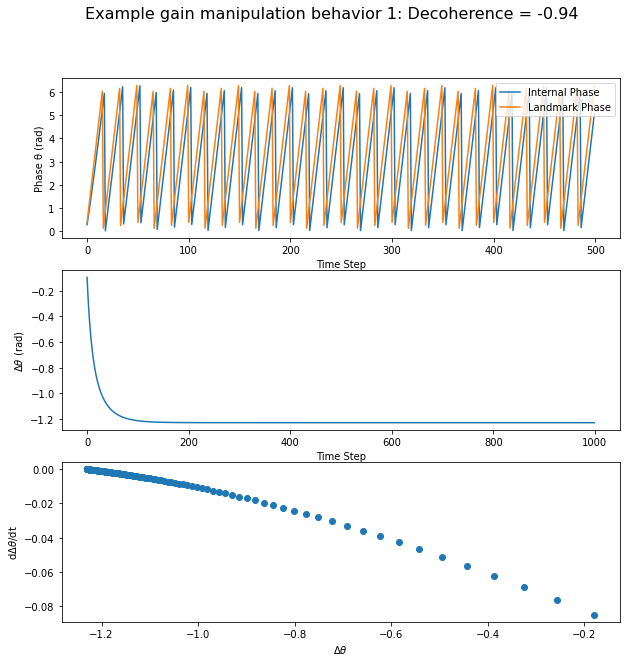

In [37]:
import copy
#phase_difference = [phaseA-phaseL for phaseA,phaseL in zip(phi_A_t,phi_L_t)]
#deltaPhi = copy.copy(phase_difference)
deltaPhi = [(np.pi-deltaPhi[i])/abs((np.pi-deltaPhi[i]))*((np.pi-deltaPhi[i])%(np.pi)) if abs(deltaPhi[i]) > np.pi else deltaPhi[i] for i in range(len(deltaPhi))]
deltaPhi_diff = np.diff(deltaPhi)
fig2, ax2 = plt.subplots(3,1,figsize=(10,10))
# peakl and peakr stores the position 
ax2[0].plot(dt*np.arange(500),phi_A_t[0:500], label = 'Internal Phase')
ax2[0].set_xlabel('Time Step')
ax2[0].set_ylabel('Phase \u03B8 (rad)')
ax2[0].plot(dt*np.arange(500),phi_L_t[0:500], label = 'Landmark Phase')
ax2[0].legend(loc='upper right')
#ax2[0].set_ylabel('Phase (rad)')
#ax2[1].plot(dt*np.arange(1000),x_t)
#ax2[1].set_xlabel('Time steps')
#ax2[1].set_ylabel('Position x (cm)')
ax2[1].plot(dt*np.arange(1000),deltaPhi)
ax2[1].set_ylabel('$\Delta\\theta$ (rad)')
ax2[1].set_xlabel('Time Step')
ax2[2].scatter(deltaPhi[1:], deltaPhi_diff)
ax2[2].set_xlabel('$\Delta\\theta$')
ax2[2].set_ylabel('d$\Delta\\theta$/dt')
#ax2[4].plot(dt*np.arange(999),deltaPhi_diff)
#ax2[4].set_ylabel('deltaPhi/dt')
fig2.suptitle('Example gain manipulation behavior 1: Decoherence = -0.94',fontsize=16)

plt.savefig()

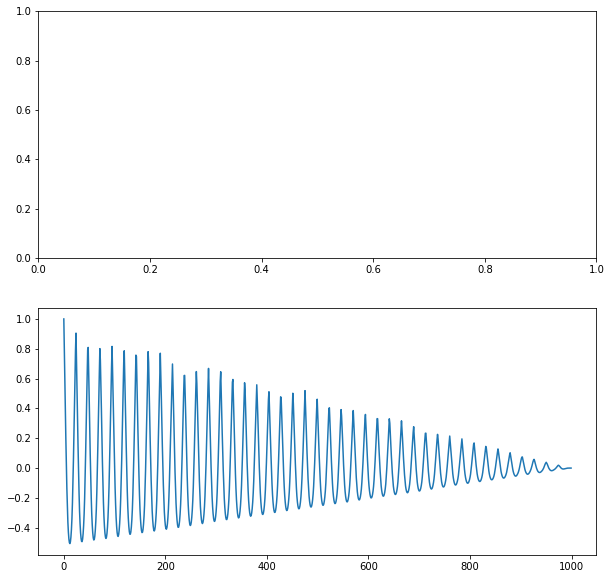

In [ ]:
# time delayed autocorr
Tstep = 10
#plt.plot(deltaPhi[1:(1000-Tstep+1)],deltaPhi[Tstep:1000])
def autocorr(input):
    input = (input - np.mean(input)) / (np.std(input)* np.sqrt(len(input)))
    #print(input) 
    result = np.correlate(input,input, mode='full')
    return result[result.size//2:]
auto_dPhi = autocorr(deltaPhi)
fig3, ax3 = plt.subplots(2,1,figsize=(10,10))
#ax3[0].plot(deltaPhi[1:(1000-Tstep+1)],deltaPhi[Tstep:1000])
ax3[1].plot(np.arange(len(auto_dPhi)),auto_dPhi)

In [ ]:
# periodic behavior by fft
def calc_major_freq(deltaPhi):
    deltaPhi = np.array(deltaPhi)
    deltaPhi_ft = np.fft.rfft(deltaPhi)
    freq = np.fft.rfftfreq(deltaPhi.shape[-1])
    #plt.plot(freq, abs(deltaPhi_ft))
    signal_freq = freq[abs(deltaPhi_ft).argmax()]
    return signal_freq

In [ ]:
def calc_constant_dPhi(deltaPhi):
    return deltaPhi[-1]